###### Importing Libraries

In [ ]:
import os
import time
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#from google.colab import drive
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###### Mounting Drive

In [ ]:
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###### Set path for testing , training and validation directories

In [ ]:
path = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN'
train_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/train'
validation_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/val'
test_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/test'

In [ ]:
train_cnv_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/train/CNV'
train_dme_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/train/DME'
train_drusen_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/train/DRUSEN'
train_normal_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/train/NORMAL'

validation_cnv_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/val/CNV'
validation_dme_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/val/DME'
validation_drusen_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/val/DRUSEN'
validation_normal_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/val/NORMAL'

test_cnv_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/test/CNV'
test_dme_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/test/DME'
test_drusen_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/test/DRUSEN'
test_normal_dir = 'C:/Users/Emmitt/Desktop/BUAP/Otoño 2024/PDI/OCT-Retinal-CNN/test/NORMAL'

In [ ]:
num_cnv_train = len(os.listdir(train_cnv_dir))
num_dme_train = len(os.listdir(train_dme_dir))
num_drusen_train = len(os.listdir(train_drusen_dir))
num_normal_train = len(os.listdir(train_normal_dir))

num_cnv_validation = len(os.listdir(validation_cnv_dir))
num_dme_validation = len(os.listdir(validation_dme_dir))
num_drusen_validation = len(os.listdir(validation_drusen_dir))
num_normal_validation = len(os.listdir(validation_normal_dir))

num_cnv_test = len(os.listdir(test_cnv_dir))
num_dme_test = len(os.listdir(test_dme_dir))
num_drusen_test = len(os.listdir(test_drusen_dir))
num_normal_test = len(os.listdir(test_normal_dir))

##### Printing Total Numbers of Testing, Training and validation images

In [ ]:
print('Total Training Images of CNV',num_cnv_train)
print('Total Training Images of DME',num_dme_train)
print('Total Training Images of DRUSEN', num_drusen_train)
print('Total Training Images of NORMAL',num_normal_train)
print('\n************************\n')
print('Total Validation Images of CNV',num_cnv_validation)
print('Total Validation Imagges of DME',num_dme_validation)
print('Total Validation Images of DRUSEN',num_drusen_validation)
print('Total Validation Images of NORMAL',num_normal_validation)
print('\n************************\n')
print('Total Testing Images of CNV',num_cnv_test)
print('Total Testing Images of DME',num_dme_test)
print('Total Testing Images of DRUSEN',num_drusen_test)
print('Total Testing Images of NORMAL',num_normal_test)

Total Training Images of CNV 37205
Total Training Images of DME 11348
Total Training Images of DRUSEN 8616
Total Training Images of NORMAL 26315

************************

Total Validation Images of CNV 8
Total Validation Imagges of DME 8
Total Validation Images of DRUSEN 8
Total Validation Images of NORMAL 8

************************

Total Testing Images of CNV 242
Total Testing Images of DME 242
Total Testing Images of DRUSEN 242
Total Testing Images of NORMAL 242


In [ ]:
total_train = num_cnv_train+num_dme_train+num_drusen_train+num_normal_train
total_validation = num_cnv_validation+num_dme_validation+num_drusen_validation+num_normal_validation
total_test = num_cnv_test+num_dme_test+num_drusen_test+num_normal_test

In [ ]:
print('Total Training Images',total_train)
print('Total Validation Images',total_validation)
print('Total Testing Images',total_test)

Total Training Images 83484
Total Validation Images 32
Total Testing Images 968


###### Defining Batch-size and image_shape for deep learning model

In [ ]:
BATCH_SIZE = 100
IMG_SHAPE  = 150

### Creamos las funciones para aplicar el procesamiento

In [ ]:
def recorte_imagen(image):
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar un umbral para obtener una imagen binaria
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Encontrar las coordenadas de los píxeles relevantes
    coords = cv2.findNonZero(thresh)  # Coordenadas de píxeles no blancos

    # Encontrar el rectángulo delimitador
    x, y, w, h = cv2.boundingRect(coords)

    # Crear una máscara negra del tamaño de la imagen original
    mask = np.zeros_like(image, dtype=np.uint8)

    # Pintar de blanco (255) el rectángulo delimitador en la máscara
    mask[y:y+h, x:x+w] = image[y:y+h, x:x+w]

    return mask

In [ ]:
def smooth_image(image, kernel_size):
    output = cv2.medianBlur(image, kernel_size)
    return output

In [ ]:
def gamma_correction(image, gamma):
    # Aplicar la corrección gamma
    corrected = np.array(255 * (image / 255) ** gamma, dtype='uint8')
    return corrected

In [ ]:
def equalize_histogram_hsv(frame, k):
    # Convertir la imagen de BGR a HSV
    image_HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Separamos los canales de la imagen
    h, s, v = cv2.split(image_HSV)

    # Calcular histograma
    hist = cv2.calcHist([v], [0], None, [256], [0, 256])
    cumulative_hist = np.cumsum(hist)

    # Obtenemos las dimensiones de la imagen
    (M, N) = v.shape

    # Factor de cambio
    dx = (k - 1) / (M * N)

    # Construimos un vector Y para almacenar los valores precalculados
    y2 = np.array([np.round(cumulative_hist[i] * dx) for i in range(256)], dtype='uint8')

    # Aplicar la ecualización al canal V
    v_equalized = y2[v]

    image_HSV = cv2.merge([h, s, v_equalized])

    # Convertir la imagen de HSV de vuelta a BGR
    result = cv2.cvtColor(image_HSV, cv2.COLOR_HSV2BGR)

    return result


In [ ]:
def ajustar_contraste_hsv(frame, alow, ahigh, amin, amax):
    # Convertir la imagen de BGR a HSV
    image_HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Trabajar con el canal V (Value)
    h, s, v = cv2.split(image_HSV)

    # Calcular histograma
    hist = cv2.calcHist([v], [0], None, [256], [0, 256])
    cumulative_hist = np.cumsum(hist)

    # Obtenemos las dimensiones de la imagen
    (M, N) = v.shape

    # Obtenemos los valores de las condiciones para a'low y a'high
    multlow = int(M * N * alow)
    multhigh = int(M * N * (1 - ahigh))

    # Obtenemos a'low y a'high  (Rango de contraste restringido)
    alowp = min([i for i in range(256) if cumulative_hist[i] >= multlow])
    ahighp = max([i for i in range(256) if cumulative_hist[i] <= multhigh])

    # Factor de cambio
    dx = (amax - amin) / (ahighp - alowp)

    # Crear una tabla de mapeo con valores ajustados
    table_map = np.array([amin if i <= alowp else amax if i >= ahighp else amin + ((i - alowp) * dx) for i in range(256)], dtype='uint8')

    # Aplicar el mapeo al canal V
    v_correct = table_map[v]

    # Reemplazar el canal V ajustado en la imagen HSV
    image_HSV = cv2.merge([h, s, v_correct])

    # Convertir la imagen de HSV de vuelta a BGR
    result = cv2.cvtColor(image_HSV, cv2.COLOR_HSV2BGR)

    return result



### Funcion para aplicar el procesamiento a cada imagen

In [ ]:
def preprocess_image(image):
    gamma = 1.5
    alow = 0.8
    ahigh = 0.0005
    amin = 0
    amax = 255
    size = 13
    k = 255

    recorte = recorte_imagen(image)
    gamma_corrected = gamma_correction(recorte, gamma)
    equalized = equalize_histogram_hsv(gamma_corrected, k)
    contrasted = ajustar_contraste_hsv(equalized, alow, ahigh, amin, amax)
    smoothed = smooth_image(contrasted, size)
    return smoothed.astype('float32')

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Creamos el Generador para pasarlo al modelo

##### Applying Data Agumentation

In [ ]:
image_gen_train = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                                     zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',
                                     preprocessing_function=preprocess_image)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='categorical')

Found 83484 images belonging to 4 classes.


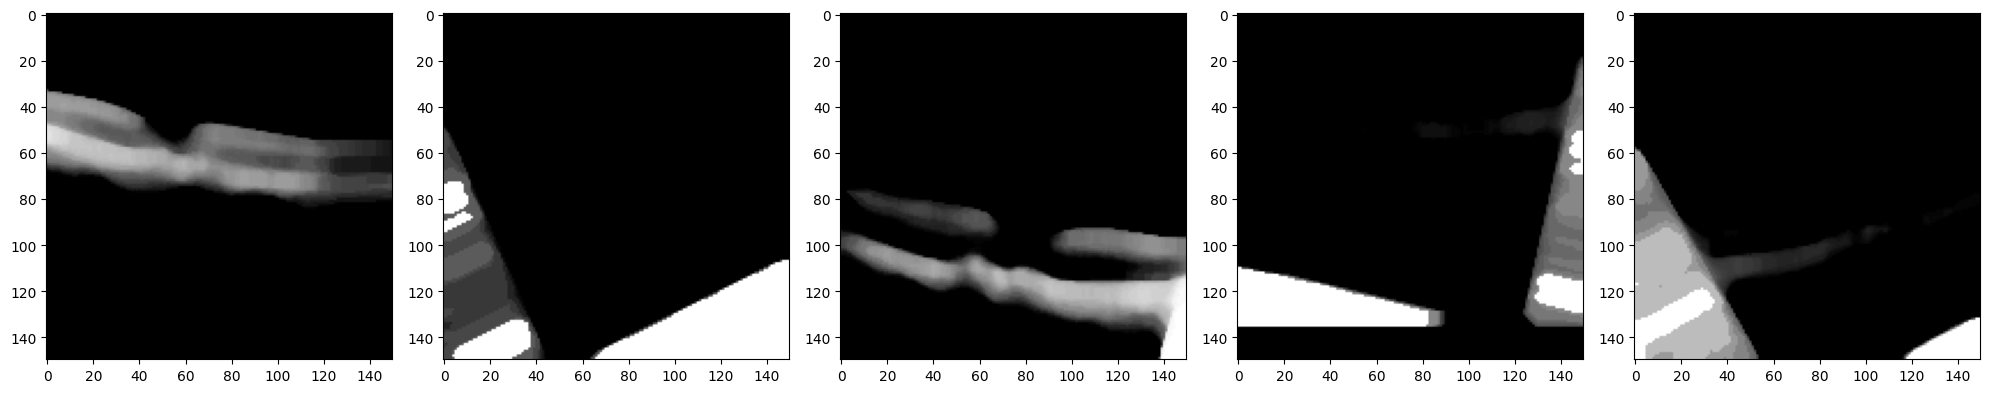

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

###### Pre-Processing for testing and validation data

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)

test_data_gen = image_gen_test.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [ ]:
model = tf.keras.models.Sequential([
    #tf.keras.layers.InputLayer(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

C:\Users\Emmitt\anaconda3\envs\env-opencv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### Defining Model Parameters

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


###### Checking Model parameters details

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

###### Let's Start Training

In [ ]:
epochs=2
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_validation / float(BATCH_SIZE))),
    verbose= 1
)

C:\Users\Emmitt\anaconda3\envs\env-opencv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
835/835 ━━━━━━━━━━━━━━━━━━━━ 1850s 2s/step - accuracy: 0.5003 - loss: 1.1627 - val_accuracy: 0.5625 - val_loss: 0.9348
Epoch 2/2
835/835 ━━━━━━━━━━━━━━━━━━━━ 1416s 2s/step - accuracy: 0.6461 - loss: 0.9098 - val_accuracy: 0.5938 - val_loss: 0.7795


###### Visualization of validation-Training (Accuracy and Loss)

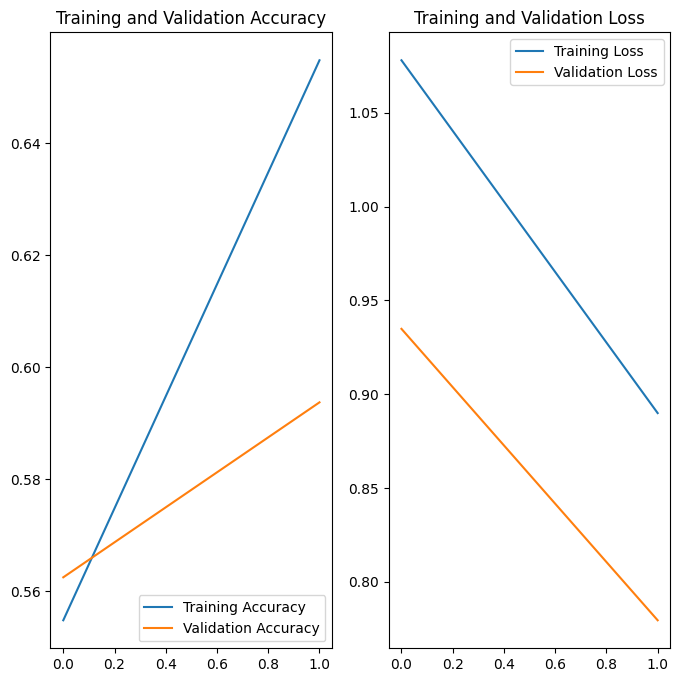

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
results = model.evaluate(test_data_gen)
print("test_loss, test accuracy",results)

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6577 - loss: 0.7740
test_loss, test accuracy [0.7861336469650269, 0.6477272510528564]


###### Saving model

In [ ]:
#t = time.time()
#export_path_keras = "./{}.h5".format(int(t))
#print(export_path_keras)
#model.save(export_path_keras)
model.save('Cat_vs_dogs_classification.h5')